# 前言  
* 这是一个复制（但不是完全照搬）别人work的分析（[来源](https://www.dataquest.io/blog/data-science-portfolio-project/)）。现在独自去处理陌生的data set有点怕怕的，先照着别人做一个练练手，也不至于走到死胡同（后来发现这是我想太多）
* 这篇分析综合了多个New York City的高中的SAT成绩，并试图找找哪些numerical variable和SAT成绩关系最大。
* 相比于原分析，我省去了画地图的部分（先把主干走一遍），更加详尽地清晰了每个数据集。

## PART I importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

先审阅一下，下面代码做了三件事：
* 用pandas把每个文件读取为DataFrame，放到一个dictionary里
* 检查下dict的key
* 检查下每个DataFrame的头几行

In [2]:
files = ["ap_2010.csv", "class_size.csv", 
         "demographics.csv", "graduation.csv", 
         "hs_directory.csv", "math_test_results.csv", 
         "sat_results.csv"]

data = {}

# 把所有dataframe放到一个dict里
for f in files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [3]:
data.keys()

dict_keys(['demographics', 'ap_2010', 'sat_results', 'graduation', 'math_test_results', 'hs_directory', 'class_size'])

In [4]:
for key, val in data.items():
    print('--'* 30 + '\n' + key + '：\n')
    print(val.head(2))

------------------------------------------------------------
demographics：

      DBN                       Name  schoolyear fl_percent  frl_percent  \
0  01M015  P.S. 015 ROBERTO CLEMENTE    20052006       89.4          NaN   
1  01M015  P.S. 015 ROBERTO CLEMENTE    20062007       89.4          NaN   

   total_enrollment prek   k grade1 grade2    ...     black_num black_per  \
0               281   15  36     40     33    ...            74      26.3   
1               243   15  29     39     38    ...            68      28.0   

  hispanic_num hispanic_per white_num white_per male_num male_per female_num  \
0          189         67.3         5       1.8    158.0     56.2      123.0   
1          153         63.0         4       1.6    140.0     57.6      103.0   

  female_per  
0       43.8  
1       42.4  

[2 rows x 38 columns]
------------------------------------------------------------
ap_2010：

      DBN                    SchoolName AP Test Takers  Total Exams Taken  \
0  01M

数据读取OK。观察每个表的头几行看到，除了class_size和hs_directory，每个表里都有一栏‘DBN’，谷歌一下知道这是学校的unique code。如果可以给class_size和hs_directory加上这一栏'DBN'，那么它之后可以作为把所有表合并为一个表的关键词。    
进一步看一下这两个表：

In [5]:
data['class_size'].head(3)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN


In [6]:
data['hs_directory'].head(3)

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026..."
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to Bronx students or residents who attend...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241..."


查谷歌知道class_size的头三栏合并一下就是'DBN'，而hs_directory的'dbn'一栏其实就等同于'DBN'。

In [7]:
# 给class_size和hs_directory两个表加上‘DBN'一栏
data["class_size"]["DBN"] = data["class_size"].apply(lambda x: "{0:02d}{1}".format(x["CSD"], x["SCHOOL CODE"]), axis=1)

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

中途发现了其它有用数据，一份是针对所有district的学校的调查，另一份是只针对district75的学校的调查，加到dictionary里：

In [9]:
survey1 = pd.read_excel(open('schools/survey_all.xlsx', 'rb'), 
                        sheetname = 'Sheet1', 
                        skiprows = [0, 1])
survey2 = pd.read_excel(open('schools/survey_d75.xlsx', 'rb'), 
                        sheetname = 'Sheet1', 
                        skiprows = [0, 1])

# 保险起见加一栏来表示来源的不同
survey1['d75'] = False
survey2['d75'] = True
survey = pd.concat([survey1, survey2], axis=0)

In [10]:
print(len(survey1.columns), len(survey2.columns))

1938 1769


虽燃两个survey的栏目不完全相同，但查询codebook得知名字相同的栏目意义是相同的，所以用pd.concat()加到一起没问题。至于不匹配的栏目，管它呢反正pd.concat()会填充NaN的。    
这一步要做的主要是有什么都收进来搁着，精挑细选是下一步的事。

In [11]:
survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,com_p_11,com_s_11,com_t_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,7.6,NaN,7.8,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,7.6,NaN,8.5,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,8.3,NaN,6.3,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,8.2,5.9,6.2,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,7.9,NaN,7.3,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


In [12]:
# 初步清洗一下survey, 加到data dictionary里
survey["DBN"] = survey["dbn"]

survey_fields = ["DBN", 
                 "rr_s", "rr_t", "rr_p", 
                 "N_s", "N_t", "N_p", 
                 "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", 
                 "saf_t_11", "com_t_11", "eng_t_10", "aca_t_11", 
                 "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", 
                 "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"
                ]
survey = survey.loc[:,survey_fields]
data["survey"] = survey
survey.shape

(1702, 23)

现在data dictionary里有7个dataframe，每个dataframe里都有一栏代表学校代码的'DBN'。

## PART II condensing and cleaning dataset

如果以'DBN'为关键词来合并所有dataframe，需要确保每个'DBN'只对应一个学校，且在同一个表里每个'DBN'只占一行。  
我们需要看看那些表里同一'DBN'出现了多次，把多行用一些aggregation func合并为一行。

In [13]:
for key in data.keys():
    print(key)
    print(len(data[key]['DBN']) - len(data[key]['DBN'].unique()))

demographics
8481
survey
0
ap_2010
1
sat_results
0
graduation
24673
math_test_results
27346
hs_directory
0
class_size
26124


可以看到在'math_test_results', 'graduation', 'ap_2010', 'class_size'和'demographcis'里至少一个DBN出现了多次。我们需要对这五个表操作一下把多行aggregate为一行。

### 2.1 condensing and cleaning math_test_results

In [15]:
math = data['math_test_results']
math.head()

,DBN,Grade,Year,Category,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,Level 3 #,Level 3 %,Level 4 #,Level 4 %,Level 3+4 #,Level 3+4 %
0,01M015,3,2006,All Students,39,667,2,5.1%,11,28.2%,20,51.3%,6,15.4%,26,66.7%
1,01M015,3,2007,All Students,31,672,2,6.5%,3,9.7%,22,71%,4,12.9%,26,83.9%
2,01M015,3,2008,All Students,37,668,0,0%,6,16.2%,29,78.4%,2,5.4%,31,83.8%
3,01M015,3,2009,All Students,33,668,0,0%,4,12.1%,28,84.8%,1,3%,29,87.9%
4,01M015,3,2010,All Students,26,677,6,23.1%,12,46.2%,6,23.1%,2,7.7%,8,30.8%


In [16]:
math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28478 entries, 0 to 28477
Data columns (total 16 columns):
DBN                 28478 non-null object
Grade               28478 non-null object
Year                28478 non-null int64
Category            28478 non-null object
Number Tested       28478 non-null int64
Mean Scale Score    23131 non-null object
Level 1 #           28478 non-null object
Level 1 %           28478 non-null object
Level 2 #           28478 non-null object
Level 2 %           28478 non-null object
Level 3 #           28478 non-null object
Level 3 %           28478 non-null object
Level 4 #           28478 non-null object
Level 4 %           28478 non-null object
Level 3+4 #         28478 non-null object
Level 3+4 %         28478 non-null object
dtypes: int64(2), object(14)
memory usage: 3.5+ MB


本应是数据的栏目，需要转换格式。

In [17]:
# func to convert type, 这个可以多次使用
def obj_to_num(data, cols_list):
    for col in cols_list:
        data[col] = data[col].str.replace('%', '')
        data[col] = pd.to_numeric(data[col], errors='coerce')
    return data

In [18]:
math.columns

Index(['DBN', 'Grade', 'Year', 'Category', 'Number Tested', 'Mean Scale Score',
       'Level 1 #', 'Level 1 %', 'Level 2 #', 'Level 2 %', 'Level 3 #',
       'Level 3 %', 'Level 4 #', 'Level 4 %', 'Level 3+4 #', 'Level 3+4 %'],
      dtype='object')

In [19]:
# 转换数据格式
math = obj_to_num(math, math.columns[5:])

In [20]:
math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28478 entries, 0 to 28477
Data columns (total 16 columns):
DBN                 28478 non-null object
Grade               28478 non-null object
Year                28478 non-null int64
Category            28478 non-null object
Number Tested       28478 non-null int64
Mean Scale Score    22731 non-null float64
Level 1 #           28057 non-null float64
Level 1 %           28057 non-null float64
Level 2 #           28057 non-null float64
Level 2 %           28057 non-null float64
Level 3 #           28057 non-null float64
Level 3 %           28057 non-null float64
Level 4 #           28057 non-null float64
Level 4 %           28057 non-null float64
Level 3+4 #         28057 non-null float64
Level 3+4 %         28057 non-null float64
dtypes: float64(11), int64(2), object(3)
memory usage: 3.5+ MB


In [21]:
math.head()

,DBN,Grade,Year,Category,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,Level 3 #,Level 3 %,Level 4 #,Level 4 %,Level 3+4 #,Level 3+4 %
0,01M015,3,2006,All Students,39,667.0,2.0,5.1,11.0,28.2,20.0,51.3,6.0,15.4,26.0,66.7
1,01M015,3,2007,All Students,31,672.0,2.0,6.5,3.0,9.7,22.0,71.0,4.0,12.9,26.0,83.9
2,01M015,3,2008,All Students,37,668.0,0.0,0.0,6.0,16.2,29.0,78.4,2.0,5.4,31.0,83.8
3,01M015,3,2009,All Students,33,668.0,0.0,0.0,4.0,12.1,28.0,84.8,1.0,3.0,29.0,87.9
4,01M015,3,2010,All Students,26,677.0,6.0,23.1,12.0,46.2,6.0,23.1,2.0,7.7,8.0,30.8


In [22]:
math = math.groupby('DBN').mean().reset_index()

In [23]:
math = math.drop('Year', axis=1)

In [24]:
math.head()

,DBN,Number Tested,Mean Scale Score,Level 1 #,Level 1 %,Level 2 #,Level 2 %,Level 3 #,Level 3 %,Level 4 #,Level 4 %,Level 3+4 #,Level 3+4 %
0,01M015,54.000000,658.850000,8.880000,16.400000,18.640000,34.74400,23.200000,42.90800,3.28000,5.940000,26.480000,48.860000
1,01M019,69.846154,675.100000,5.360000,6.740000,16.520000,23.67200,37.200000,50.73600,13.52000,18.848000,50.720000,69.584000
2,01M020,144.640000,679.100000,6.720000,4.636000,26.800000,18.72400,83.360000,57.24000,27.76000,19.404000,111.120000,76.640000
3,01M034,80.047619,662.162162,10.047619,11.595238,26.857143,31.97619,35.619048,45.52619,7.52381,10.897619,43.142857,56.428571
4,01M063,46.080000,675.050000,2.880000,6.340000,9.600000,22.02400,25.920000,54.75200,7.68000,16.880000,33.600000,71.632000


In [25]:
len(math.DBN) - math.DBN.nunique()

0

In [26]:
data['math_test_results'] = math

### 2.2 clean 'graduation' dataset

In [27]:
grad = data['graduation']
grad.head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


's'代表的应该是missing value。还好pd.to_numeric可以设置errors='coerce'，不用重新读一边数据。

In [28]:
grad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25096 entries, 0 to 25095
Data columns (total 23 columns):
Demographic                           25096 non-null object
DBN                                   25096 non-null object
School Name                           25096 non-null object
Cohort                                25096 non-null object
Total Cohort                          25096 non-null int64
Total Grads - n                       25096 non-null object
Total Grads - % of cohort             25096 non-null object
Total Regents - n                     25096 non-null object
Total Regents - % of cohort           25096 non-null object
Total Regents - % of grads            25051 non-null object
Advanced Regents - n                  25096 non-null object
Advanced Regents - % of cohort        25096 non-null object
Advanced Regents - % of grads         25051 non-null object
Regents w/o Advanced - n              25096 non-null object
Regents w/o Advanced - % of cohort    25096 non-null

In [29]:
# 转换格式
grad = obj_to_num(grad, grad.columns[5:])
grad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25096 entries, 0 to 25095
Data columns (total 23 columns):
Demographic                           25096 non-null object
DBN                                   25096 non-null object
School Name                           25096 non-null object
Cohort                                25096 non-null object
Total Cohort                          25096 non-null int64
Total Grads - n                       16704 non-null float64
Total Grads - % of cohort             16704 non-null float64
Total Regents - n                     16704 non-null float64
Total Regents - % of cohort           16704 non-null float64
Total Regents - % of grads            16652 non-null float64
Advanced Regents - n                  16704 non-null float64
Advanced Regents - % of cohort        16704 non-null float64
Advanced Regents - % of grads         16652 non-null float64
Regents w/o Advanced - n              16704 non-null float64
Regents w/o Advanced - % of cohort    16704

In [30]:
grad.head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37.0,67.3,17.0,30.9,45.9,...,17.0,30.9,45.9,20.0,36.4,54.1,15.0,27.3,3.0,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43.0,67.2,27.0,42.2,62.8,...,27.0,42.2,62.8,16.0,25.0,37.2,9.0,14.1,9.0,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43.0,55.1,36.0,46.2,83.7,...,36.0,46.2,83.7,7.0,9.0,16.3,16.0,20.5,11.0,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44.0,56.4,37.0,47.4,84.1,...,37.0,47.4,84.1,7.0,9.0,15.9,15.0,19.2,11.0,14.1


现在数据类型转换好了，思考下保留那些column，去掉哪些column；以及名字看起来有关联性的几栏之间是什么关系。

In [31]:
grad.Cohort.value_counts()   #  太早年份的信息，还是去掉吧

2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64

In [32]:
mask = (grad.Cohort=='2001')|(grad.Cohort=='2002')|(grad.Cohort=='2003')|(grad.Cohort=='2004')

grad = grad[~mask]

In [33]:
grad.Demographic.value_counts()    # 这个可以贡献什么信息？
                                   # 如果同一个'DBN'在Demographic一栏有多个值，该咋合并？

Special Education Students     1217
Total Cohort                   1200
General Education Students     1197
English Proficient Students    1190
Female                         1172
Black                          1171
Male                           1170
Hispanic                       1166
English Language Learners       996
Asian                           877
White                           868
Name: Demographic, dtype: int64

In [34]:
len(grad[['Demographic', 'DBN', 'Cohort']].groupby(['Demographic', 'DBN']).count())

4261

In [35]:
grad.DBN.nunique()

413

从上面得知同一个学校的确有多个Demographic的值，那么在这个表的aggregation里，Demographic会被drop掉啦，虽然它提供了一些可能有用的信息。  
但是没关系，还有个表专门记学校的demographic信息呢（hs_directory）。

还得思考下Total Rengents, Advanced Rengents, Rengents w/o Advanced, Local分别是什么意思。  

Do some google search I know that there are three types of diploma: advanced rengents, rengents, and local. The former is better than the latter.

In [36]:
grad.head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43.0,67.2,27.0,42.2,62.8,...,27.0,42.2,62.8,16.0,25.0,37.2,9.0,14.1,9.0,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43.0,55.1,36.0,46.2,83.7,...,36.0,46.2,83.7,7.0,9.0,16.3,16.0,20.5,11.0,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44.0,56.4,37.0,47.4,84.1,...,37.0,47.4,84.1,7.0,9.0,15.9,15.0,19.2,11.0,14.1
9,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2005,121,64.0,52.9,35.0,28.9,54.7,...,31.0,25.6,48.4,29.0,24.0,45.3,41.0,33.9,11.0,9.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53.0,42.7,42.0,33.9,79.2,...,34.0,27.4,64.2,11.0,8.9,20.8,46.0,37.1,20.0,16.1


头几行都出现了’Total Regents - % of cohort‘的值和’Regents w/o Advanced - % of cohort‘值相等。为了进一步探究这两栏的关系，跳出它们的值不等的行：

In [37]:
mask = grad['Total Regents - % of cohort'] == grad['Regents w/o Advanced - % of cohort']

In [38]:
grad[~mask].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
9,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2005,121,64.0,52.9,35.0,28.9,54.7,...,31.0,25.6,48.4,29.0,24.0,45.3,41.0,33.9,11.0,9.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53.0,42.7,42.0,33.9,79.2,...,34.0,27.4,64.2,11.0,8.9,20.8,46.0,37.1,20.0,16.1
11,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006 Aug,124,60.0,48.4,42.0,33.9,70.0,...,34.0,27.4,56.7,18.0,14.5,30.0,39.0,31.5,20.0,16.1
23,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2005,88,49.0,55.7,38.0,43.2,77.6,...,20.0,22.7,40.8,11.0,12.5,22.4,20.0,22.7,14.0,15.9
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47.0,56.0,40.0,47.6,85.1,...,23.0,27.4,48.9,7.0,8.3,14.9,25.0,29.8,5.0,6.0


从上面可以看出来，advanced rengent是total rangent的一个子集，而local, still enrolled, dropped out和total rangent没有交集。

In [39]:
# 进一步探究下col之间的的关系，撇开百分比，只看绝对值
sus_cols = ['DBN', 'Cohort', 'Total Cohort',
       'Total Grads - n',  'Total Regents - n', 
       'Advanced Regents - n', 'Regents w/o Advanced - n',
       'Local - n',  'Still Enrolled - n',
       'Dropped Out - n']
grad[~mask][sus_cols].head(10)

,DBN,Cohort,Total Cohort,Total Grads - n,Total Regents - n,Advanced Regents - n,Regents w/o Advanced - n,Local - n,Still Enrolled - n,Dropped Out - n
9,01M448,2005,121,64.0,35.0,4.0,31.0,29.0,41.0,11.0
10,01M448,2006,124,53.0,42.0,8.0,34.0,11.0,46.0,20.0
11,01M448,2006 Aug,124,60.0,42.0,8.0,34.0,18.0,39.0,20.0
23,01M509,2005,88,49.0,38.0,18.0,20.0,11.0,20.0,14.0
24,01M509,2006,84,47.0,40.0,17.0,23.0,7.0,25.0,5.0
25,01M509,2006 Aug,84,50.0,41.0,18.0,23.0,9.0,22.0,5.0
30,01M515,2005,154,70.0,56.0,45.0,11.0,14.0,64.0,20.0
31,01M515,2006,193,105.0,91.0,69.0,22.0,14.0,53.0,35.0
32,01M515,2006 Aug,193,105.0,91.0,69.0,22.0,14.0,53.0,35.0
37,01M539,2005,49,47.0,47.0,38.0,9.0,0.0,2.0,0.0


* 'Total Cohort'的层级结构和包含关系：
    * 'Total Grads - n'
        * 'Total Regents - n'
            * 'Advanced Regents - n'
            * 'Regents w/o Advanced - n'
        * 'Local - n'
    * 'Still Enrolled - n'
    * 'Dropped Out - n'

虽然这里有很多内相关，但我又没打算建模，姑且都留着所有栏目吧。

In [40]:
grad = grad.groupby(['DBN','School Name']).mean().reset_index()

In [41]:
grad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 21 columns):
DBN                                   413 non-null object
School Name                           413 non-null object
Total Cohort                          413 non-null float64
Total Grads - n                       382 non-null float64
Total Grads - % of cohort             382 non-null float64
Total Regents - n                     382 non-null float64
Total Regents - % of cohort           382 non-null float64
Total Regents - % of grads            382 non-null float64
Advanced Regents - n                  382 non-null float64
Advanced Regents - % of cohort        382 non-null float64
Advanced Regents - % of grads         382 non-null float64
Regents w/o Advanced - n              382 non-null float64
Regents w/o Advanced - % of cohort    382 non-null float64
Regents w/o Advanced - % of grads     382 non-null float64
Local - n                             382 non-null float64
Local - % of

In [42]:
# codebook里有说对于人数小于等于5的cohort，不把毕业数据纳入计算。
# 对于我们的目的，这些行留着也没用，drop掉。
grad = grad.dropna()

In [43]:
grad.info()

print(len(grad.DBN) - grad.DBN.nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 0 to 412
Data columns (total 21 columns):
DBN                                   382 non-null object
School Name                           382 non-null object
Total Cohort                          382 non-null float64
Total Grads - n                       382 non-null float64
Total Grads - % of cohort             382 non-null float64
Total Regents - n                     382 non-null float64
Total Regents - % of cohort           382 non-null float64
Total Regents - % of grads            382 non-null float64
Advanced Regents - n                  382 non-null float64
Advanced Regents - % of cohort        382 non-null float64
Advanced Regents - % of grads         382 non-null float64
Regents w/o Advanced - n              382 non-null float64
Regents w/o Advanced - % of cohort    382 non-null float64
Regents w/o Advanced - % of grads     382 non-null float64
Local - n                             382 non-null float64
Local - % of

In [44]:
len(grad) - grad.DBN.nunique()

0

In [45]:
data['graduation'] = grad

### 2.3 clean 'ap_2010'

In [58]:
ap = data['ap_2010']
ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
DBN                                     258 non-null object
SchoolName                              258 non-null object
AP Test Takers                          233 non-null float64
Total Exams Taken                       258 non-null object
Number of Exams with scores 3 4 or 5    258 non-null object
dtypes: float64(1), object(4)
memory usage: 10.2+ KB


In [47]:
# 只有一个DBN出现了两次，看看它是谁
ap.DBN.value_counts().head()

04M610    2
17K537    1
31R600    1
13K605    1
30Q450    1
Name: DBN, dtype: int64

In [48]:
ap.loc[data['ap_2010'].DBN=='04M610', :]

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
51,04M610,THE YOUNG WOMEN'S LEADERSHIP SCHOOL OF EAST HA...,41,55,29
52,04M610,YOUNG WOMEN'S LEADERSHIP SCH,s,s,s


可能是录入时搞重了。目测转换下格式然后dropna()就行。

In [60]:
# 转换格式
ap = obj_to_num(ap, ap.columns[3:])

In [49]:
ap.columns

Index(['DBN', 'SchoolName', 'AP Test Takers ', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5'],
      dtype='object')

In [51]:
ap.columns = ap.columns.str.strip()

In [61]:
ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
DBN                                     258 non-null object
SchoolName                              258 non-null object
AP Test Takers                          233 non-null float64
Total Exams Taken                       233 non-null float64
Number of Exams with scores 3 4 or 5    151 non-null float64
dtypes: float64(3), object(2)
memory usage: 10.2+ KB


In [62]:
# 把数字的三列全空的行drop掉
mask = (ap['AP Test Takers'].isnull()) & (ap['Total Exams Taken'].isnull()) & (ap['Number of Exams with scores 3 4 or 5'].isnull())

In [63]:
mask.sum()

25

In [64]:
ap = ap[~mask]

In [65]:
ap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 257
Data columns (total 5 columns):
DBN                                     233 non-null object
SchoolName                              233 non-null object
AP Test Takers                          233 non-null float64
Total Exams Taken                       233 non-null float64
Number of Exams with scores 3 4 or 5    151 non-null float64
dtypes: float64(3), object(2)
memory usage: 10.9+ KB


In [66]:
len(ap.DBN) - ap.DBN.nunique()

0

In [67]:
data['ap_2010'] = ap

### 2.4 clean 'class_size'

In [68]:
cls = data['class_size']
cls.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01M015


In [69]:
cls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27611 entries, 0 to 27610
Data columns (total 17 columns):
CSD                                     27611 non-null int64
BOROUGH                                 27611 non-null object
SCHOOL CODE                             27611 non-null object
SCHOOL NAME                             27611 non-null object
GRADE                                   26127 non-null object
PROGRAM TYPE                            26127 non-null object
CORE SUBJECT (MS CORE and 9-12 ONLY)    26127 non-null object
CORE COURSE (MS CORE and 9-12 ONLY)     26127 non-null object
SERVICE CATEGORY(K-9* ONLY)             26127 non-null object
NUMBER OF STUDENTS / SEATS FILLED       26127 non-null float64
NUMBER OF SECTIONS                      26127 non-null float64
AVERAGE CLASS SIZE                      26127 non-null float64
SIZE OF SMALLEST CLASS                  26127 non-null float64
SIZE OF LARGEST CLASS                   26127 non-null float64
DATA SOURCE        

In [70]:
cls.columns

Index(['CSD', 'BOROUGH', 'SCHOOL CODE', 'SCHOOL NAME', 'GRADE ',
       'PROGRAM TYPE', 'CORE SUBJECT (MS CORE and 9-12 ONLY)',
       'CORE COURSE (MS CORE and 9-12 ONLY)', 'SERVICE CATEGORY(K-9* ONLY)',
       'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS',
       'DATA SOURCE', 'SCHOOLWIDE PUPIL-TEACHER RATIO', 'DBN'],
      dtype='object')

In [71]:
cls['GRADE '].value_counts()

09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64

In [72]:
cls['PROGRAM TYPE'].value_counts()

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

In [73]:
# 从中选择高中
mask = (cls['PROGRAM TYPE']=='GEN ED') & (cls['GRADE ']=='09-12')

In [74]:
cls = cls.loc[mask]

我们需要的几栏已经是float格式了，因此没必要做转换，直接groupby吧

In [75]:
cls = cls.groupby(['DBN', 'SCHOOL NAME']).mean().reset_index()

In [76]:
cls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 9 columns):
DBN                                  583 non-null object
SCHOOL NAME                          583 non-null object
CSD                                  583 non-null int64
NUMBER OF STUDENTS / SEATS FILLED    583 non-null float64
NUMBER OF SECTIONS                   583 non-null float64
AVERAGE CLASS SIZE                   583 non-null float64
SIZE OF SMALLEST CLASS               583 non-null float64
SIZE OF LARGEST CLASS                583 non-null float64
SCHOOLWIDE PUPIL-TEACHER RATIO       0 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 41.1+ KB


In [77]:
# drop redundant cols
cls = cls.drop(['CSD', 'SCHOOLWIDE PUPIL-TEACHER RATIO'], axis=1)

In [78]:
# convert column names into lowercase
cls.columns = cls.columns.str.lower()

In [79]:
cls.head()

,dbn,school name,number of students / seats filled,number of sections,average class size,size of smallest class,size of largest class
0,01M292,Henry Street School for International Studies,88.0000,4.000000,22.564286,18.50,26.571429
1,01M332,University Neighborhood Middle School,46.0000,2.000000,22.000000,21.00,23.500000
2,01M378,School for Global Leaders,33.0000,1.000000,33.000000,33.00,33.000000
3,01M448,University Neighborhood High School,105.6875,4.750000,22.231250,18.25,27.062500
4,01M450,East Side Community School,57.6000,2.733333,21.200000,19.40,22.866667


In [92]:
# 要保持和其它表的一致性，dbn一栏还得大写
cls = cls.rename(columns={'dbn':'DBN'})

In [93]:
data['class_size'] = cls

### 2.5 cleaning 'demographics'

In [82]:
demo = data['demographics']
demo.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [83]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 38 columns):
DBN                  10075 non-null object
Name                 10075 non-null object
schoolyear           10075 non-null int64
fl_percent           8566 non-null object
frl_percent          4482 non-null float64
total_enrollment     10075 non-null int64
prek                 4712 non-null object
k                    5882 non-null object
grade1               5881 non-null object
grade2               5851 non-null object
grade3               5779 non-null object
grade4               5741 non-null object
grade5               5777 non-null object
grade6               4517 non-null object
grade7               4203 non-null object
grade8               4085 non-null object
grade9               3974 non-null object
grade10              3846 non-null object
grade11              3674 non-null object
grade12              3513 non-null object
ell_num              9885 non-null float64
ell_p

谷歌一下知道，美国的high school指的是grade9 - grade 12。([来源](http://www.go2travel.com.tw/PA/education/kiski/system.htm))

In [84]:
# 把grade9 - grade12不全为空的行保留下来
mask = (demo.grade9.isnull()) & (demo.grade10.isnull()) & (demo.grade11.isnull()) & (demo.grade12.isnull())

demo = demo[~mask]

In [85]:
demo.columns

Index(['DBN', 'Name', 'schoolyear', 'fl_percent', 'frl_percent',
       'total_enrollment', 'prek', 'k', 'grade1', 'grade2', 'grade3', 'grade4',
       'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11',
       'grade12', 'ell_num', 'ell_percent', 'sped_num', 'sped_percent',
       'ctt_num', 'selfcontained_num', 'asian_num', 'asian_per', 'black_num',
       'black_per', 'hispanic_num', 'hispanic_per', 'white_num', 'white_per',
       'male_num', 'male_per', 'female_num', 'female_per'],
      dtype='object')

In [86]:
# 转换格式
cols = ['fl_percent', 'ctt_num', 'selfcontained_num']

demo = obj_to_num(demo, cols)

/Users/EzraYang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/EzraYang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [87]:
demo = demo.groupby(['DBN']).mean().reset_index()
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 23 columns):
DBN                  1550 non-null object
schoolyear           1550 non-null float64
fl_percent           490 non-null float64
frl_percent          1520 non-null float64
total_enrollment     1550 non-null float64
ell_num              1549 non-null float64
ell_percent          1549 non-null float64
sped_num             1549 non-null float64
sped_percent         1550 non-null float64
ctt_num              1531 non-null float64
selfcontained_num    1535 non-null float64
asian_num            1550 non-null float64
asian_per            1550 non-null float64
black_num            1550 non-null float64
black_per            1550 non-null float64
hispanic_num         1550 non-null float64
hispanic_per         1550 non-null float64
white_num            1550 non-null float64
white_per            1550 non-null float64
male_num             1550 non-null float64
male_per             1550 non-null 

In [88]:
demo = demo.drop('schoolyear', axis=1)
len(demo) - demo.DBN.nunique()

0

In [89]:
data['demographics'] = demo

In [95]:
try:  
    for key in data.keys():
        print(key, ': ')
        print(len(data[key]) - data[key]['DBN'].nunique())
except:
    print(key, ' got error.')

demographics : 
0
survey : 
0
ap_2010 : 
0
sat_results : 
0
graduation : 
0
math_test_results : 
0
hs_directory : 
0
class_size : 
0


Now we've condensed 'math_test_results', 'graduation', 'ap_2010', 'class_size' and 'demographcis' dataframe, each DBN in each dataframe is unique.

## PART III clean other data sets

We still have the following 3 datasets to look at and do some basic cleaning: 'hs_directory', 'survey', 'sat_results'.

### 3.1 clean 'hs_directory'

In [96]:
hs = data['hs_directory']
hs.head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to Queens students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680


In [97]:
hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 59 columns):
dbn                                 435 non-null object
school_name                         435 non-null object
boro                                435 non-null object
building_code                       435 non-null object
phone_number                        435 non-null object
fax_number                          423 non-null object
grade_span_min                      435 non-null object
grade_span_max                      435 non-null int64
expgrade_span_min                   33 non-null object
expgrade_span_max                   33 non-null float64
bus                                 434 non-null object
subway                              358 non-null object
primary_address_line_1              435 non-null object
city                                435 non-null object
state_code                          435 non-null object
zip                                 435 non-null int64
we

In [98]:
hs.grade_span_min = pd.to_numeric(hs.grade_span_min, errors='coerce')

In [99]:
hs = hs.loc[(hs.grade_span_min <= 9)&(hs.grade_span_max >= 9), :]
hs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432 entries, 0 to 434
Data columns (total 59 columns):
dbn                                 432 non-null object
school_name                         432 non-null object
boro                                432 non-null object
building_code                       432 non-null object
phone_number                        432 non-null object
fax_number                          420 non-null object
grade_span_min                      432 non-null float64
grade_span_max                      432 non-null int64
expgrade_span_min                   32 non-null object
expgrade_span_max                   32 non-null float64
bus                                 431 non-null object
subway                              356 non-null object
primary_address_line_1              432 non-null object
city                                432 non-null object
state_code                          432 non-null object
zip                                 432 non-null int64
w

观察到有很多栏目的值可能比较复杂，take a look：

In [100]:
cols = ['school_type', 'advancedplacement_courses', 'online_ap_courses', 
        'extracurricular_activities', 'school_sports', 'partner_cbo', 
        'partner_hospital', 'partner_highered', 'partner_cultural', 
        'partner_nonprofit', 'partner_corporate', 'partner_financial', 
        'partner_other', 'se_services', 'ell_programs', 'number_programs']

In [101]:
for col in cols:
    print('--' * 20)
    print(col + ':\n')
    print(hs[col].value_counts().head(2))

----------------------------------------
school_type:

CTE School           36
Consortium School    17
Name: school_type, dtype: int64
----------------------------------------
advancedplacement_courses:

English Literature and Composition, United States History    10
English Literature and Composition                            8
Name: advancedplacement_courses, dtype: int64
----------------------------------------
online_ap_courses:

Biology                         3
Spanish Language and Culture    3
Name: online_ap_courses, dtype: int64
----------------------------------------
extracurricular_activities:

Campus Senate, Cartooning/Anime, Chess Club and Team, Creative Writing, English Classes for English Language Learners (ELLs), Fashion and Modeling, Mural Painting, Required Math and English Language Arts (ELA) After-school Tutoring, Saturday Regents Preparation, Salsa Dance, SAT Preparation, School Newspaper, Step, Student Leadership, Student Government, Young Runner's Team, Campus-

方便起见，吧合作伙伴的栏目从comma seperated string 转换成合作伙伴的数量：

In [102]:
try:
    for col in cols[1:-1]:
        hs.loc[:, col] = hs[col].fillna('').str.split(',')
        hs.loc[:, col] = hs[col].apply(lambda x: 0 if x == [''] else len(x))
except:
    print(col)

/Users/EzraYang/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [103]:
for col in cols:
    print('--' * 20)
    print(col + ':\n')
    print(hs[col].value_counts().head(2))

----------------------------------------
school_type:

CTE School           36
Consortium School    17
Name: school_type, dtype: int64
----------------------------------------
advancedplacement_courses:

0    95
3    46
Name: advancedplacement_courses, dtype: int64
----------------------------------------
online_ap_courses:

0    368
2     17
Name: online_ap_courses, dtype: int64
----------------------------------------
extracurricular_activities:

12    28
13    24
Name: extracurricular_activities, dtype: int64
----------------------------------------
school_sports:

0    138
1     78
Name: school_sports, dtype: int64
----------------------------------------
partner_cbo:

1    90
0    81
Name: partner_cbo, dtype: int64
----------------------------------------
partner_hospital:

0    236
1    125
Name: partner_hospital, dtype: int64
----------------------------------------
partner_highered:

1    90
2    64
Name: partner_highered, dtype: int64
----------------------------------------
p

Now they are all in int type.

In [104]:
hs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432 entries, 0 to 434
Data columns (total 59 columns):
dbn                                 432 non-null object
school_name                         432 non-null object
boro                                432 non-null object
building_code                       432 non-null object
phone_number                        432 non-null object
fax_number                          420 non-null object
grade_span_min                      432 non-null float64
grade_span_max                      432 non-null int64
expgrade_span_min                   32 non-null object
expgrade_span_max                   32 non-null float64
bus                                 431 non-null object
subway                              356 non-null object
primary_address_line_1              432 non-null object
city                                432 non-null object
state_code                          432 non-null object
zip                                 432 non-null int64
w

In [105]:
# adding lat and lon columns
hs['lat'] = hs['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[0])
hs['lon'] = hs['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[1])

for c in ['lat', 'lon']:
    hs[c] = pd.to_numeric(hs[c])

/Users/EzraYang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/EzraYang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/EzraYang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [106]:
data['hs_directory'] = hs

### 3.2 clean 'survey' dataset 

In [107]:
sv = data['survey']
sv.head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,NaN,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,NaN,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


In [108]:
sv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Data columns (total 23 columns):
DBN           1702 non-null object
rr_s          1041 non-null float64
rr_t          1702 non-null int64
rr_p          1702 non-null int64
N_s           1036 non-null float64
N_t           1700 non-null float64
N_p           1696 non-null float64
saf_p_11      1696 non-null float64
com_p_11      1696 non-null float64
eng_p_11      1696 non-null float64
aca_p_11      1696 non-null float64
saf_t_11      1700 non-null float64
com_t_11      1700 non-null float64
eng_t_10      0 non-null float64
aca_t_11      1700 non-null float64
saf_s_11      1036 non-null float64
com_s_11      1036 non-null float64
eng_s_11      1036 non-null float64
aca_s_11      1036 non-null float64
saf_tot_11    1702 non-null float64
com_tot_11    1702 non-null float64
eng_tot_11    1702 non-null float64
aca_tot_11    1702 non-null float64
dtypes: float64(20), int64(2), object(1)
memory usage: 319.1+ KB


In [ ]:
# it's clean enough, don't have to do nothing

### 3.3 clean 'sat_results'

In [109]:
sat = data['sat_results']
sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [110]:
sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


In [111]:
sat.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score'],
      dtype='object')

In [112]:
cols = ['Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score']

In [113]:
sat = obj_to_num(sat, cols)

In [114]:
sat['sat_score'] = sat[cols[1]] + sat[cols[2]] + sat[cols[3]]

In [115]:
sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 7 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             421 non-null float64
SAT Critical Reading Avg. Score    421 non-null float64
SAT Math Avg. Score                421 non-null float64
SAT Writing Avg. Score             421 non-null float64
sat_score                          421 non-null float64
dtypes: float64(5), object(2)
memory usage: 26.2+ KB


In [116]:
data['sat_results'] = sat

Now we have looked into each of the datasets in the 'data' dictionary, we've made sure each row represents a unique school, extract useful columns, and convert data type wherever necessary.  
Next we can combine them into one single dataframe.

## PART IV combining the dataset and some more cleaning 

In [117]:
data.keys()

dict_keys(['demographics', 'survey', 'ap_2010', 'sat_results', 'graduation', 'math_test_results', 'hs_directory', 'class_size'])

In [118]:
full = data['sat_results']

In [119]:
for key in ['hs_directory', 'survey', 'math_test_results', 'graduation',
            'ap_2010', 'class_size', 'demographics']:
    full = full.merge(data[key], on='DBN', how='left')  # 以有sat_score的学校为准

In [120]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Columns: 152 entries, DBN to female_per
dtypes: float64(109), object(43)
memory usage: 571.4+ KB


In [121]:
full.shape

(478, 152)

In [122]:
# add a column to indicate school district
full["school_dist"] = full["DBN"].apply(lambda x: x[:2])

Finally, we’ll need to fill in any missing values in full with the median of the column, so we can compute correlations:

In [123]:
full = full.fillna(full.median())

## PART V computing correlations

In [124]:
full.corr().shape

(109, 109)

In [125]:
r = full.corr()['sat_score'].dropna().round(decimals=2)

In [126]:
strong = r[abs(r) >= 0.7]
upper_med = r[(0.7> abs(r)) & (abs(r)>= 0.5)]
lower_med = r[(0.5 > abs(r)) & (abs(r)>= 0.3)]
weak = r[0.3 > abs(r) ]

In [127]:
for gr in [strong, upper_med, lower_med, weak]:
    print(len(gr))

6
11
24
64


In [128]:
strong.sort_values(ascending=False)

sat_score                          1.00
SAT Writing Avg. Score             0.98
SAT Critical Reading Avg. Score    0.97
SAT Math Avg. Score                0.95
Advanced Regents - % of cohort     0.77
Advanced Regents - % of grads      0.74
Name: sat_score, dtype: float64

In [129]:
upper_med.sort_values(ascending=False)

white_per                               0.64
Advanced Regents - n                    0.62
Total Regents - % of cohort             0.60
AP Test Takers                          0.55
Total Exams Taken                       0.54
Total Regents - n                       0.54
asian_per                               0.53
Number of Exams with scores 3 4 or 5    0.53
advancedplacement_courses               0.52
fl_percent                             -0.67
frl_percent                            -0.69
Name: sat_score, dtype: float64

In [130]:
lower_med.sort_values(ascending=False)

Num of SAT Test Takers               0.49
Total Grads - % of cohort            0.48
Total Regents - % of grads           0.47
Total Grads - n                      0.47
asian_num                            0.45
N_p                                  0.44
white_num                            0.44
N_s                                  0.43
total_students                       0.41
extracurricular_activities           0.41
number of students / seats filled    0.39
average class size                   0.37
number of sections                   0.36
female_num                           0.33
total_enrollment                     0.32
size of largest class                0.31
N_t                                  0.30
ell_percent                         -0.33
sped_percent                        -0.36
hispanic_per                        -0.36
Still Enrolled - % of cohort        -0.37
Local - % of cohort                 -0.40
Dropped Out - % of cohort           -0.44
Local - % of grads                

In [135]:
weak.sort_values(ascending=False)

male_num                              0.29
Total Cohort                          0.29
rr_s                                  0.27
saf_t_11                              0.27
size of smallest class                0.25
aca_s_11                              0.25
Level 4 %                             0.25
saf_tot_11                            0.24
Level 3+4 %                           0.24
saf_s_11                              0.23
Mean Scale Score                      0.23
Regents w/o Advanced - n              0.22
Level 4 #                             0.22
Level 3+4 #                           0.19
partner_highered                      0.18
number_programs                       0.16
aca_tot_11                            0.15
partner_cultural                      0.14
com_s_11                              0.13
eng_s_11                              0.13
aca_t_11                              0.12
Level 3 %                             0.11
rr_p                                  0.10
Level 3 #  

In [131]:
# 把columns按照不同来源打出来，方便extract columns of interest
for key in data.keys():
    print(key, ':')
    print(data[key].columns)

demographics :
Index(['DBN', 'fl_percent', 'frl_percent', 'total_enrollment', 'ell_num',
       'ell_percent', 'sped_num', 'sped_percent', 'ctt_num',
       'selfcontained_num', 'asian_num', 'asian_per', 'black_num', 'black_per',
       'hispanic_num', 'hispanic_per', 'white_num', 'white_per', 'male_num',
       'male_per', 'female_num', 'female_per'],
      dtype='object')
survey :
Index(['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11',
       'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_10',
       'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11',
       'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11'],
      dtype='object')
ap_2010 :
Index(['DBN', 'SchoolName', 'AP Test Takers', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5'],
      dtype='object')
sat_results :
Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score

先来看一看variable of interest, sat_score的分布情况，它是否符合一个正态分布？

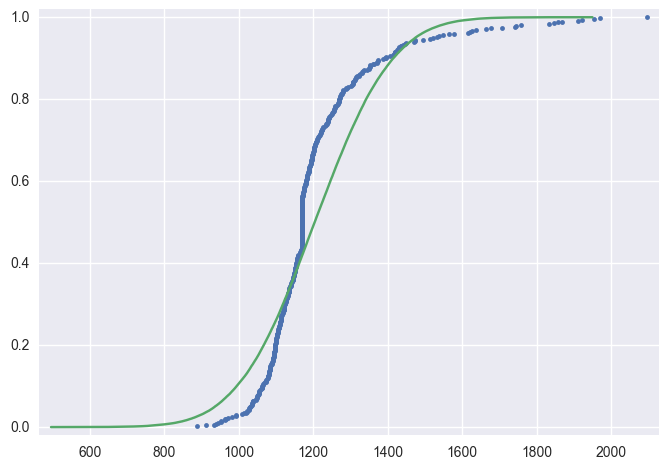

In [132]:
# 用ECDF来看一看sat_score的分布情况
mu = np.mean(full.sat_score)
std = np.std(full.sat_score)

x_real = full.sat_score.sort_values()
y_real = np.arange(1, len(x_real) + 1) / len(x_real)

x_theo = np.sort(np.random.normal(mu, std, 100000))
y_theo = np.arange(1, len(x_theo) + 1) / len(x_theo)

_ = plt.plot(x_real, y_real, marker='.', linestyle='none')
_ = plt.plot(x_theo, y_theo)

plt.margins(0.02)

plt.show()

上面做的事：
* 先计算出sat_score的均值mu和标准差std，然后用它们生成相应均值的正态分布，是为如果sat_score服从正态分布的理论值。
* 把理论值和实际值都画出来。对于曲线上的一个点，sat_score，纵轴乘100是这个点在所有点当中超过别人的percentile
* 蓝色为实际的数据点，绿色为理论上正态分布。

可以看出：
* sat_score并不是正态分布
* 没有人得极低分，极少有人得极高分：大部分人都在中间塞着呢。
* 在中间区域（比如说1050-1300），正是因为人很多，只要提高一点点的分数，就能超越大把的人。这是努力学习的回报率最高的阶段。
* 在右端区域（>1500）要提高很多分才能超过一点点的人。

用bee plot来验证下是不是：

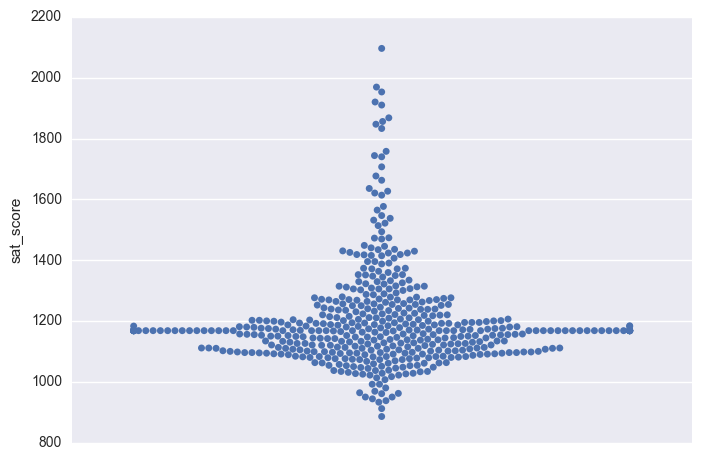

In [133]:
sns.swarmplot(y='sat_score', data=full)

果真是这样。如果用percentile来衡量的话，1200左右的人好惨。。。比底端那一部分努力了，明明再高一点percentile就可以猛升的，然而还是停留在庸常的大多数的区间里。   

好，回来看其它变量和sat_score的相关度。

除了用来构建sat_score的变量和sat_score本身，和sat_score相关性最强的是‘Advanced Rengents % of cohort'. 其它几个描述毕业生情况的变量也有不低的相关性。总体来说，描述毕业生去向的这个数据集和sat_score是最有关系的。

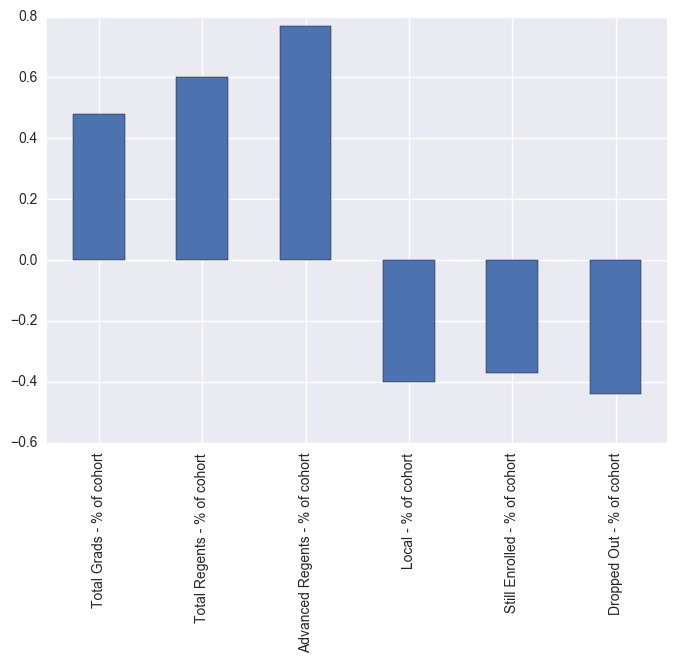

In [134]:
r[['Total Grads - % of cohort',
       'Total Regents - % of cohort', 'Advanced Regents - % of cohort',
       'Local - % of cohort', 'Still Enrolled - % of cohort',
       'Dropped Out - % of cohort']].plot.bar()

In [136]:
concern = ['fl_percent', 'frl_percent', 'total_enrollment', 'ell_num',
       'ell_percent', 'sped_num', 'sped_percent', 'ctt_num',
       'selfcontained_num', 'asian_num', 'asian_per', 'black_num', 'black_per',
       'hispanic_num', 'hispanic_per', 'white_num', 'white_per', 'male_num',
       'male_per', 'female_num', 'female_per']

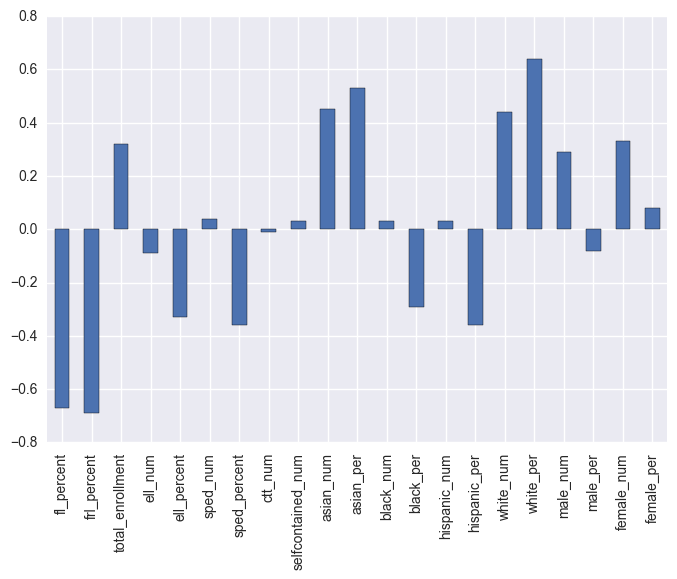

In [137]:
r[concern].plot.bar()

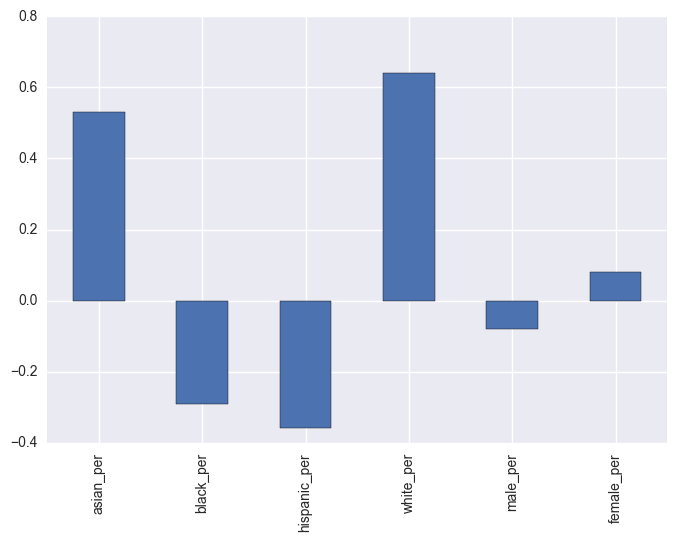

In [138]:
r[['asian_per', 'black_per', 'hispanic_per', 'white_per',
       'male_per', 'female_per']].plot.bar()

关于学校人口构成的变量，白人和亚裔所占比重和sata_score有中等强度正相关性；黑人和拉丁裔有中下强度的负相关性；性别比重则与sat_score相关性微弱。    

至于有中强负相关性的fl_percent和frl_percent，数据来源并没有解释它们是什么，也没有提供codebook，只能放到一边了。   

现在来看ap test的情况：

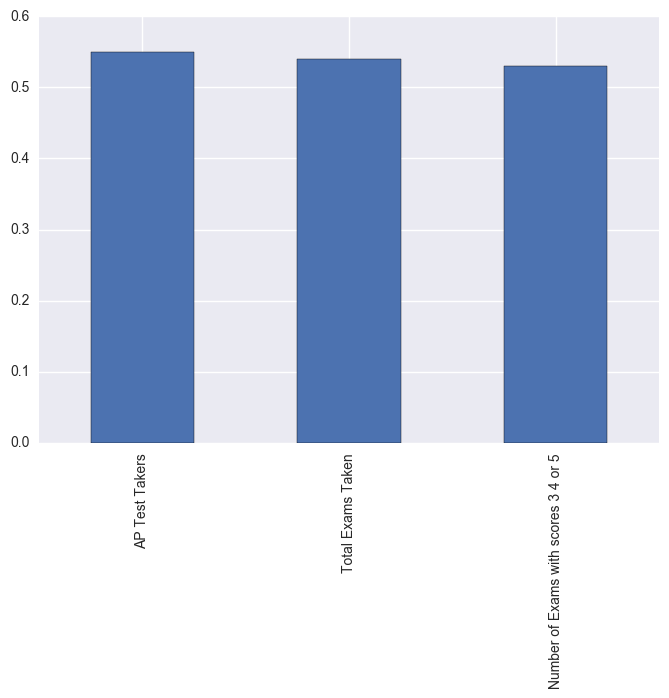

In [139]:
r[['AP Test Takers', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5']].plot.bar()

参加AP测试的人数越多，AP测试的总数越多，拿到高分的AP测试越多，则we would expect a higher sat_score of that school.  
This result seems reasonable, but the 3 variable is measured in absolute value, not a percentage. Therefore, there could be a bias in favor of the population in that school.

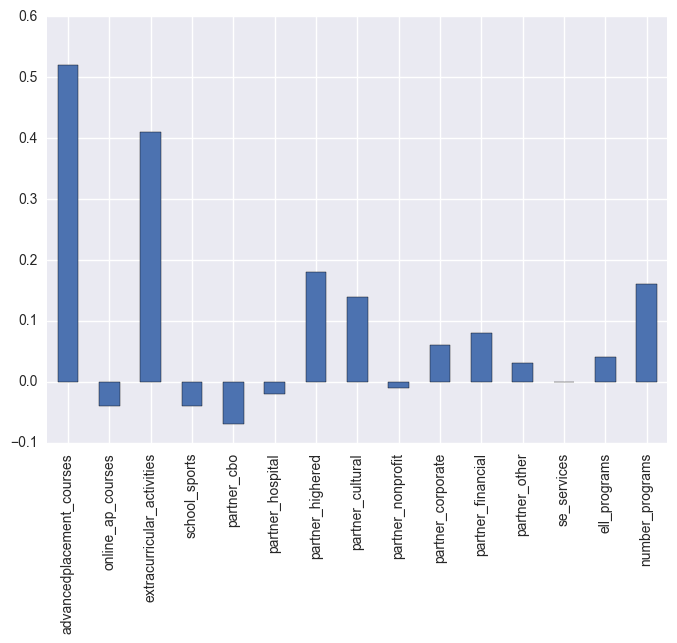

In [140]:
r[['advancedplacement_courses', 'online_ap_courses',
       'extracurricular_activities', 'school_sports', 'partner_cbo',
       'partner_hospital', 'partner_highered', 'partner_cultural',
       'partner_nonprofit', 'partner_corporate', 'partner_financial',
       'partner_other', 'se_services', 'ell_programs', 'number_programs']].plot.bar()

在所有衡量学校资源多少的变量中，只有两个与sat_score有中等强度的相关性(advancedplacement_courses and extracurricular_activities)；其余变量，诸如与学校建立合作关系的医院、高等教育机构、文化机构等的数量都与sat_score关系微弱。当然，学校的社会资源用’与之有合作关系的机构数量‘来衡量并不准确，但起码在已有数据中我们可以说相关性最显著的还是AP课程的数量和课外活动的数量。  

出人意料的是，在线AP课程的数量和sat_score不仅关系微弱，而且是负相关。

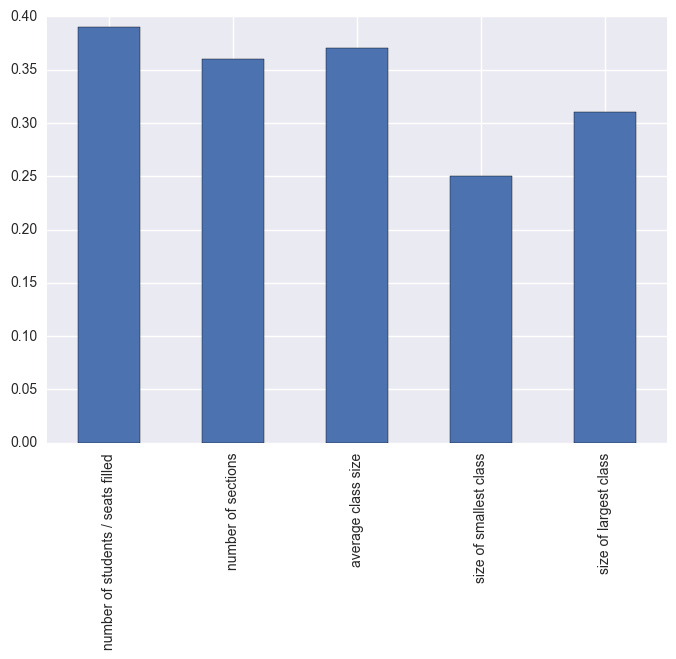

In [142]:
r[['number of students / seats filled',
       'number of sections', 'average class size', 'size of smallest class',
       'size of largest class']].plot.bar()

描述课堂规模的五个变量均和sat_score有中等强度的正相关。

在关于调查结果变量中，只有参与调查学生数、参与调查家长数与sat_score有中等强度相关性。与前面提到的课堂规模、参与AP测试的人数类似，参与调查的学生数和家长数是用绝对值衡量，都和一所学校的总人口相关。

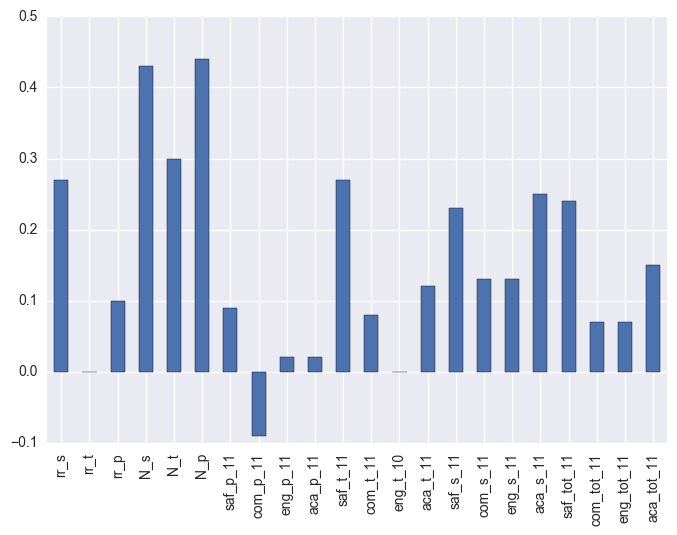

In [143]:
r[['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11',
       'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_10',
       'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11',
       'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']].plot.bar()

测试一下这几个用绝对人数来衡量的变量的内相关性。

In [145]:
r.popu = full.corr()[['advancedplacement_courses', 
'extracurricular_activities','number of students / seats filled',
       'number of sections', 'average class size', 'size of smallest class',
       'size of largest class', 'N_s', 'N_p']].loc[('advancedplacement_courses', 
'extracurricular_activities','number of students / seats filled',
       'number of sections', 'average class size', 'size of smallest class',
       'size of largest class', 'N_s', 'N_p'), :]

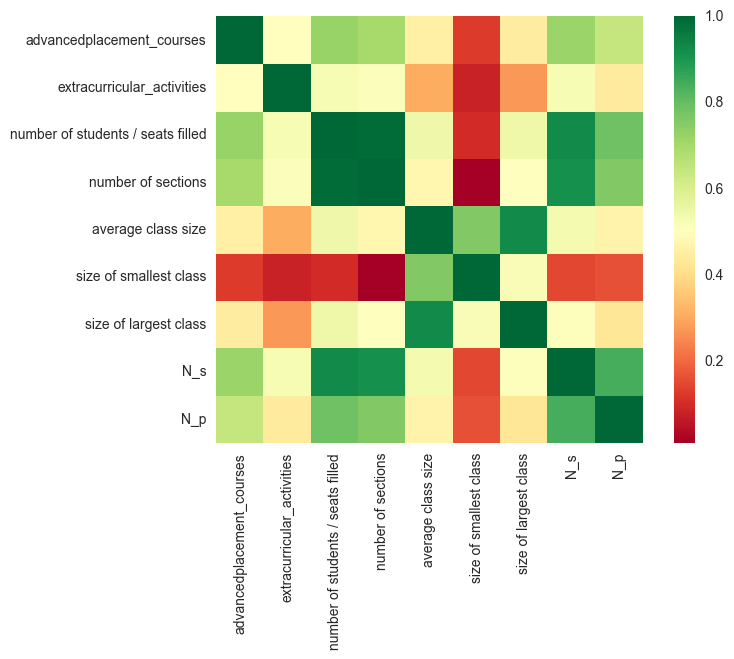

In [146]:
sns.heatmap(r.popu, square=True, cmap='RdYlGn')

嗯。。没有像想象中那样一篇全绿，’SIZE OF SMALLEST CLASS‘和很多变量是负相关的，还有很多相互之间相关度并不大的变量。

# 后记

第一次自己去八这么多data set啊，虽然是照着别人趟过的路开始的，但还是跟用数据库里的clean data set或是上课用的data set接触起来感受大有不同。而且别看这么短短一篇最后也没太挖掘出什么有用信息的analysis，我因为一些缘故做了三遍，花了超多时间。。。  

第一遍重做是到了计算correlation那里才发现我没有转换数据格式，导致很多数字是储存为object格式的，它们在计算correlation时就自动被忽略了。于是推到重来。我去follow的那篇分析中人家博主为了更好说明怎样用项目构建建立（而非单纯在讲项目），省掉了很多tedious cleaning work，但他省掉的部分我跟着省就SB了T_T。  

第二遍重做是发现到分析的时候我觉得内相关想要调查一下的total enrollment变量早在清洗时被我删了。。。不甘心，推倒重来。  

总结一下吧：
* 终于体会到了data science 90%的时间是在数据清洗，感受到了清洗的套路，df.info()和转换格式非常有用
* 清洗阶段特别注意转换格式
    * (1)因为到合并了df时，full有太多栏，报错比较难发现到底哪里出错
    * (2)趁着清洗还能好好熟悉单个data set
* 清洗阶段别轻易删变量啊，能留都留着，判断哪些有用哪些没有那是分析阶段的事